# Exploratory Data Analysis

In [4]:
import pandas as pd

df = pd.read_excel('../data/cleaned/daily_sentences_cleaned.xlsx')
df['month'] = df['Date'].dt.month

View different frequencies of my entries

<Axes: title={'center': 'Entries by Year'}, xlabel='Year'>

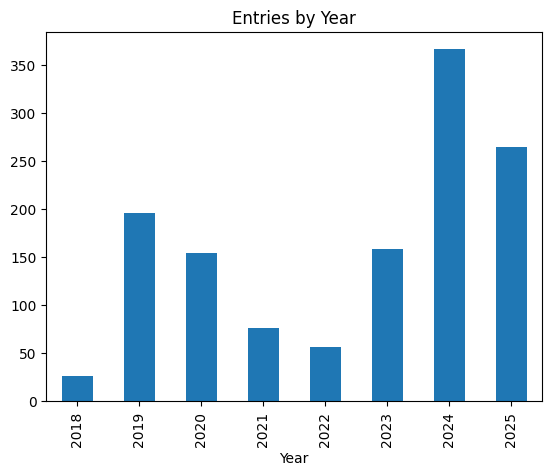

In [2]:
df.groupby(['Year']).size().plot(kind='bar', title='Entries by Year')

View number of entries for each month. As you can see, I tend to write a few more entries during the summer months, then it starts to trickle down during fall/winter.
It also spikes in January when I am highly motivated!

<Axes: title={'center': 'Entries by Month'}, xlabel='month'>

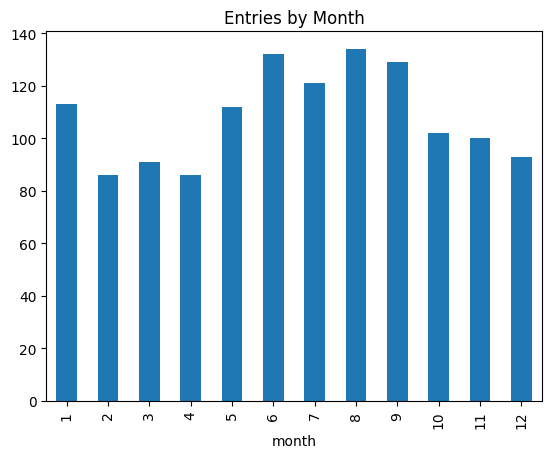

In [6]:
df.groupby(['month']).size().plot(kind='bar', title='Entries by Month')

Displayed it for consistency but does not show much. Obviously the 31st should have half the number of records

<Axes: title={'center': 'Entries by Day of Month'}, xlabel='Day'>

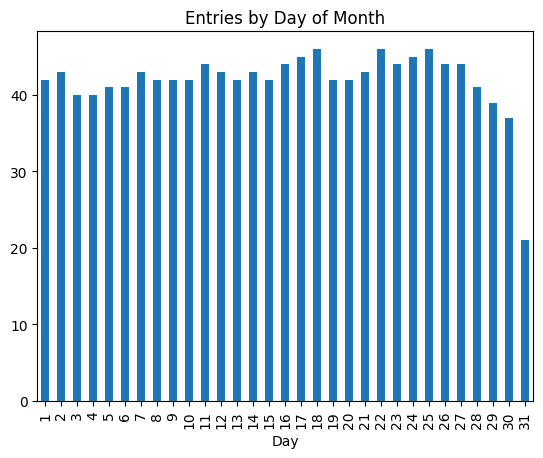

In [8]:
df.groupby(['Day']).size().plot(kind='bar', title='Entries by Day of Month')

## Statistics
For each entry, it would be interesting to see the number of characters and the number of words as an average.
Grouping by each year, I have pretty consistently written more in my journal, but around 2022 it's around the same.

Average character count per entry: 84.14
Average word count per entry: 15.29


<Axes: title={'center': 'Average Word Count per Year'}, xlabel='Year'>

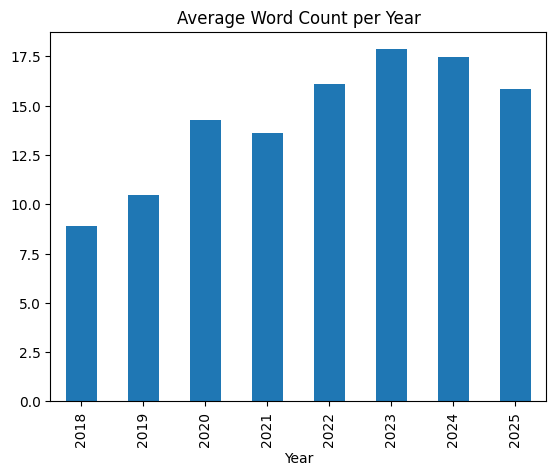

In [9]:
avg_char_count = df['Sentence'].str.len().mean()
print('Average character count per entry:', round(avg_char_count, 2))

avg_word_count = df["Sentence"].str.split().str.len().mean()
print('Average word count per entry:', round(avg_word_count, 2))

df.groupby(['Year'])['Sentence'].apply(lambda x: x.str.split().str.len().mean()).plot(kind='bar', title='Average Word Count per Year')

Next up is coverage - seeing how often I actually fill out my journal out of the possible days.
Overall, I fill it out almost 50% of the time, but the past 2 years I have done much better!

In [10]:
start_date = df['Date'].min()
end_date = df['Date'].max()
total_days = (end_date - start_date).days + 1
total_entries = df.shape[0]
percentage_filled = (total_entries / total_days) * 100
print(f"Percentage of days with entries: {percentage_filled:.2f}%")

# Function to compute year coverage
def year_coverage(df):
    coverage = []
    for year, group in df.groupby('Year'):
        start = pd.Timestamp(year=year, month=1, day=1)
        end = pd.Timestamp(year=year, month=12, day=31)

        # Clamp to your overall range
        start = max(start, start_date)
        end = min(end, end_date)

        total_days = (end - start).days + 1
        actual_days = group['Date'].nunique()
        percent = (actual_days / total_days) * 100
        coverage.append({'Year': year, 'Days Logged': actual_days,
                         'Possible Days': total_days, 'Coverage %': round(percent, 2)})
    return pd.DataFrame(coverage)

coverage_df = year_coverage(df)
print(coverage_df)

Percentage of days with entries: 48.49%
   Year  Days Logged  Possible Days  Coverage %
0  2018           26            208       12.50
1  2019          196            365       53.70
2  2020          154            366       42.08
3  2021           76            365       20.82
4  2022           57            365       15.62
5  2023          159            365       43.56
6  2024          366            366      100.00
7  2025          265            279       94.98


Let's visualize this

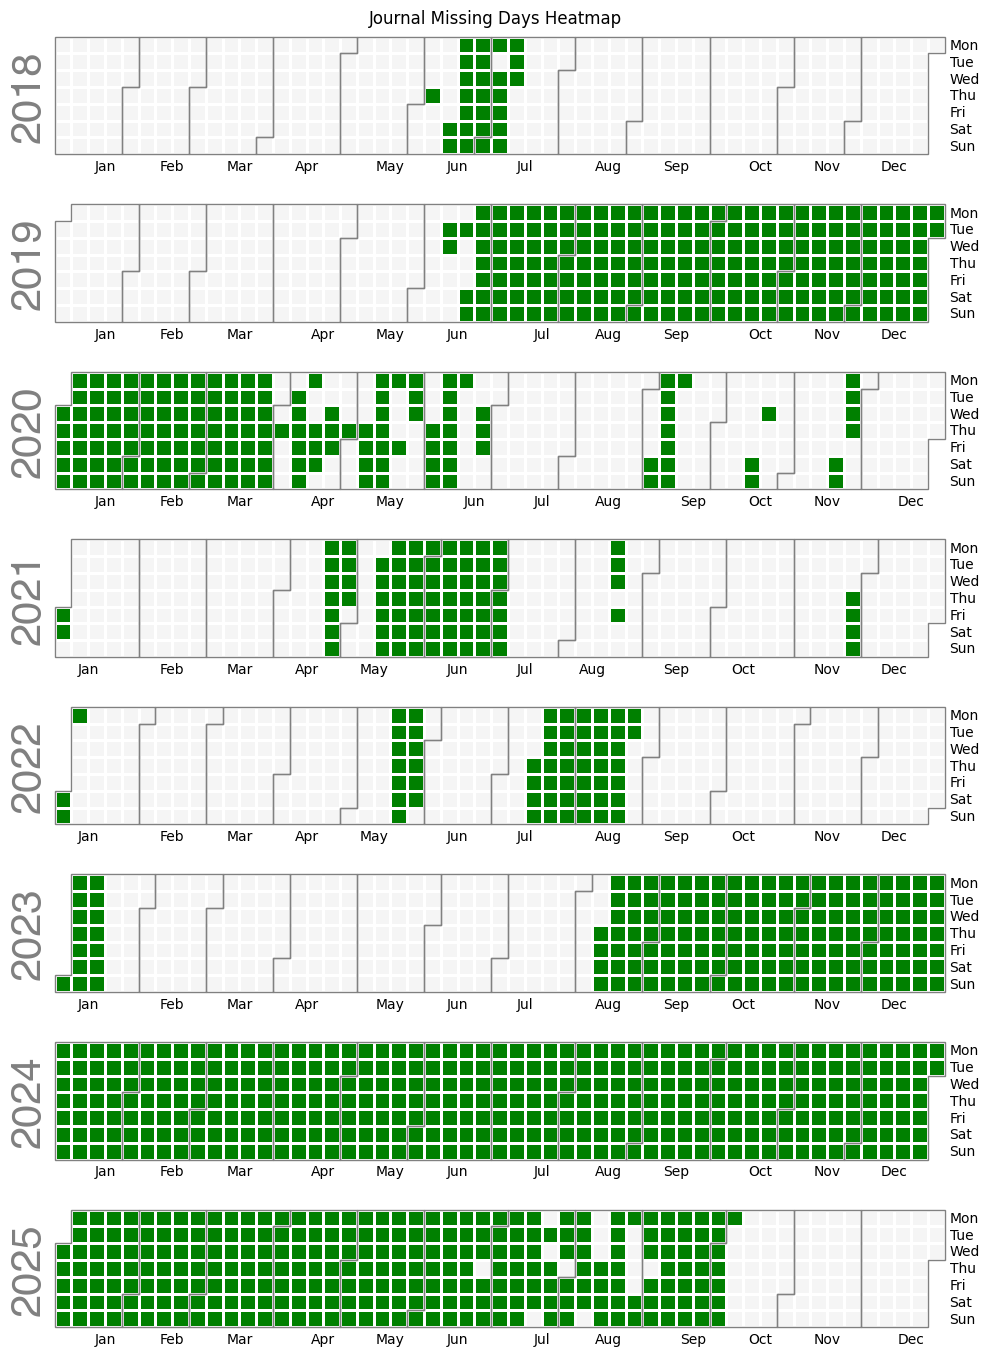

In [11]:
import calplot
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

daily = df.groupby('Date').size()  # counts per day
daily = daily.reindex(pd.date_range(df['Date'].min(), df['Date'].max()), fill_value=0)
binary_daily = daily.copy()
binary_daily[binary_daily > 0] = 1 

cmap = ListedColormap(['lightgrey', 'green'])  # 0=missing, 1=written
calplot.calplot(
    binary_daily,
    cmap=cmap,
    vmin=0,
    vmax=1,
    suptitle='Journal Missing Days Heatmap',
    colorbar=False
)
plt.show()